In [141]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import sklearn.impute as imp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


In [2]:
data_presplit = pd.read_csv('BackOrder_v2.csv')

In [3]:
data_presplit

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0,NaN,0,0,0,0,0,0,0,...,0,-99.00,-99.00,0,No,No,No,Yes,No,No
1,1043384,2,9.0,0,0,0,0,0,0,0,...,0,0.99,0.99,0,No,No,No,Yes,No,No
2,1043696,2,NaN,0,0,0,0,0,0,0,...,0,-99.00,-99.00,0,Yes,No,No,Yes,No,No
3,1043852,7,8.0,0,0,0,0,0,0,0,...,0,0.10,0.13,0,No,No,No,Yes,No,No
4,1044048,8,NaN,0,0,0,0,0,0,0,...,0,-99.00,-99.00,0,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1407727,0,2.0,0,2,2,2,0,0,0,...,0,0.63,0.72,0,Yes,No,No,Yes,No,No
1048571,1407728,359,2.0,176,224,504,840,116,195,200,...,0,0.92,0.84,0,Yes,No,No,Yes,No,No
1048572,1407730,0,NaN,0,0,0,0,0,0,0,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1048573,1407731,0,2.0,0,12,12,12,0,0,0,...,0,0.24,0.28,0,No,No,No,No,No,No


In [4]:
#data = data_presplit.drop('sku',axis=1)
#Y = data_presplit['went_on_backorder']
#X = data_presplit.drop('went_on_backorder', axis = 1)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [5]:
data_presplit['sku'].value_counts().unique()

array([1], dtype=int64)

We can see that the sku column has unique values with no repetition. Hence it doesn't provide any new information to the data or the chance of back-order as it is from a uniform distribution. Hence we can remove this column

In [6]:
# dropping sku column
data_presplit = data_presplit.drop('sku',axis = 1)

# splitting response column from predictor columns
Y = data_presplit['went_on_backorder']
data_presplit = data_presplit.drop('went_on_backorder', axis = 1)

In [7]:
Y.value_counts()

No     1039675
Yes       8900
Name: went_on_backorder, dtype: int64

In [8]:
## Detecting Quantitave and Qualitative attributes
def qual_quant_features(data):
    dtypes = list(map(lambda x:str(x),list(data.dtypes)))
    qualitative = []
    quantitative = []
    for i in range(len(dtypes)):
        if dtypes[i] == 'object':
            qualitative.append(data.columns[i])
        else:
            quantitative.append(data.columns[i])
    return qualitative,quantitative

qualitative,quantitative = qual_quant_features(data_presplit)

In [9]:
#qualitative predictors
qualitative

['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop']

In [10]:
# quantitative predictors
quantitative

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty']

In [11]:
def class_describe(categorical_data):
    col_name = []
    class_count = []
    class_1 = []
    class_2 = []
    for col in categorical_data.columns:
        col_name.append(col)
        class_count.append(categorical_data[col].unique().shape[0])
        class_1.append(categorical_data[col].unique()[0])
        class_2.append(categorical_data[col].unique()[1])
    return pd.DataFrame({'Column':col_name, 'No. of classes':class_count, 'Class 1':class_1, 'Class 2':class_2})

class_describe(data_presplit[qualitative])
        

,Column,No. of classes,Class 1,Class 2
0,potential_issue,2,No,Yes
1,deck_risk,2,No,Yes
2,oe_constraint,2,No,Yes
3,ppap_risk,2,No,Yes
4,stop_auto_buy,2,Yes,No
5,rev_stop,2,No,Yes


All our categorical columns have only 2 classes 'Yes' and 'No'. Hence we shall numerically encode them as 'Yes':1 and 'No':0

In [12]:
for col in data_presplit[qualitative].columns:
    data_presplit[col] = data_presplit[col].apply(lambda x:0 if x == 'No' else 1)

In [13]:
data_presplit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1048575 non-null  int64  
 1   lead_time          984057 non-null   float64
 2   in_transit_qty     1048575 non-null  int64  
 3   forecast_3_month   1048575 non-null  int64  
 4   forecast_6_month   1048575 non-null  int64  
 5   forecast_9_month   1048575 non-null  int64  
 6   sales_1_month      1048575 non-null  int64  
 7   sales_3_month      1048575 non-null  int64  
 8   sales_6_month      1048575 non-null  int64  
 9   sales_9_month      1048575 non-null  int64  
 10  min_bank           1048575 non-null  int64  
 11  potential_issue    1048575 non-null  int64  
 12  pieces_past_due    1048575 non-null  int64  
 13  perf_6_month_avg   1048575 non-null  float64
 14  perf_12_month_avg  1048575 non-null  float64
 15  local_bo_qty       1048575 non-n

In [14]:
data_presplit.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,0,NaN,0,0,0,0,0,0,0,0,...,0,0,-99.00,-99.00,0,0,0,0,1,0
1,2,9.0,0,0,0,0,0,0,0,0,...,0,0,0.99,0.99,0,0,0,0,1,0
2,2,NaN,0,0,0,0,0,0,0,0,...,0,0,-99.00,-99.00,0,1,0,0,1,0
3,7,8.0,0,0,0,0,0,0,0,0,...,0,0,0.10,0.13,0,0,0,0,1,0
4,8,NaN,0,0,0,0,0,0,0,4,...,0,0,-99.00,-99.00,0,1,0,0,1,0


In [15]:
# Analyzing missing values
def missing_analysis(data):
    missing_count = []
    percent_missing = []
    n_row = data.shape[0]
    for col in data.columns:
        missing_count.append(data[col].isnull().sum())
        percent_missing.append(missing_count[-1]/n_row*100)
    return pd.DataFrame({'Column':data.columns, 'No. of missing values':missing_count, 'Percentage Missing':percent_missing})

missing_analysis(data_presplit)        

,Column,No. of missing values,Percentage Missing
0,national_inv,0,0.000000
1,lead_time,64518,6.152922
2,in_transit_qty,0,0.000000
3,forecast_3_month,0,0.000000
4,forecast_6_month,0,0.000000
5,forecast_9_month,0,0.000000
6,sales_1_month,0,0.000000
7,sales_3_month,0,0.000000
8,sales_6_month,0,0.000000
9,sales_9_month,0,0.000000


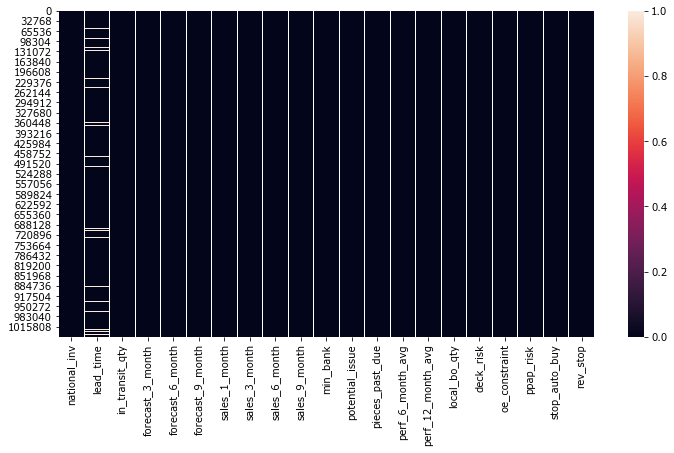

In [16]:
plt.figure(figsize=(12,6))
sns.heatmap(data_presplit.isnull())

It seems the 'lead_time' column has missing values

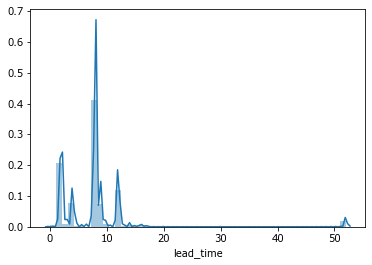

In [17]:
sns.distplot(data_presplit['lead_time'])

In [18]:
# filling missing values with the median
data_presplit['lead_time'] = data_presplit['lead_time'].fillna(data_presplit['lead_time'].median())
missing_analysis(data_presplit)

,Column,No. of missing values,Percentage Missing
0,national_inv,0,0.0
1,lead_time,0,0.0
2,in_transit_qty,0,0.0
3,forecast_3_month,0,0.0
4,forecast_6_month,0,0.0
5,forecast_9_month,0,0.0
6,sales_1_month,0,0.0
7,sales_3_month,0,0.0
8,sales_6_month,0,0.0
9,sales_9_month,0,0.0


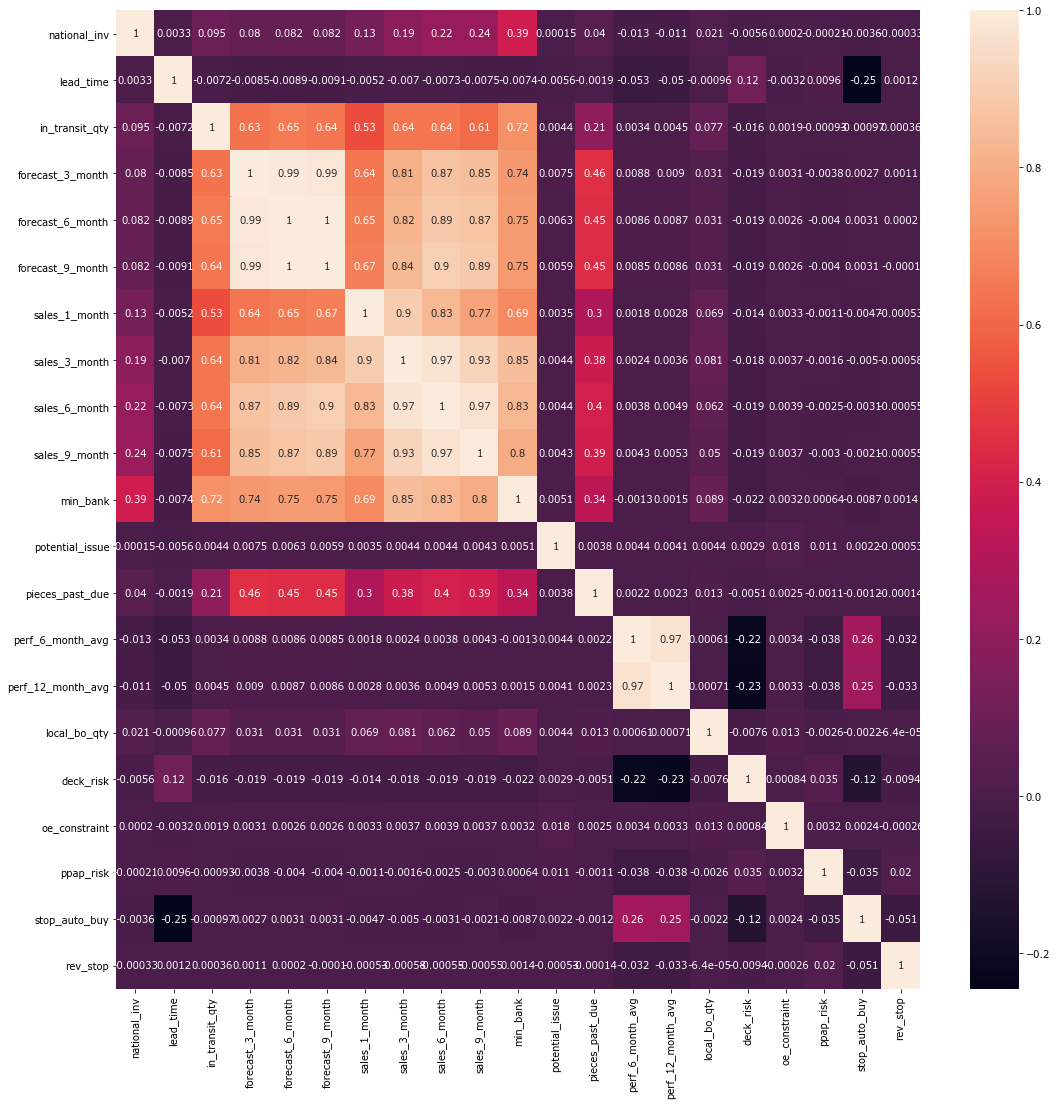

In [63]:
# correlation plot of the dataset.
plt.figure(figsize=(18,18))
sns.heatmap(data_presplit.corr(), annot = True)

From the heatmap, it seems that certain features like in_transit_qty, sales_X_month, forecast_X_month, min_bank are highly correlated. This is expected as features like forecast and demand are always correlated in normal situations.

In [19]:
def resp_freq(response):
    freq = response.value_counts()
    perc = np.array(freq)/np.array(freq).sum()*100
    return pd.DataFrame({'No. of Occurances':freq, 'Percent Occurance':perc})

resp_freq(Y)

,No. of Occurances,Percent Occurance
No,1039675,99.151229
Yes,8900,0.848771


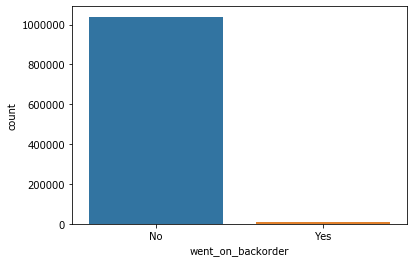

In [20]:
sns.countplot(Y)

From the response frequency analysis, the dataset is imbalanced (class skewed) as only 0.8% of the records have a 'Yes' class.
Hence a Naive classifier that always predicts 'No' will have an accuracy of 0.9915. Hence accuracy isn't the best metric for this dataset. The Naive Information Rate (NIR) of this dataset is 0.9915. This is the lower limit of acceptable performance (accuracy) for any classfier we build.

Let us see the confusion matrix for a naive classifier that always predicts a 'No'

In [21]:
naive_pred = np.zeros(data_presplit.shape[0])
actual_Y = np.array(Y.apply(lambda x:0 if x == 'No' else 1))

In [22]:
# confusion matrix of a Naive 'No' backorder classifier
confusion_matrix(actual_Y, naive_pred)

array([[1039675,       0],
       [   8900,       0]], dtype=int64)

In [23]:
precision_score(actual_Y, naive_pred)

C:\Users\chait\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [24]:
recall_score(actual_Y, naive_pred)

0.0

We can see that the precision and recall are both 0 because the naive classifier fails to predict the second class ('Yes') even once. Hence we need to use recal, precision and F1-score to compare classifiers for imbalanced datasets. To improve training data and algorithm performance, we can artificially oversample the minority response class data records using the SMOTE technique. This lets the algorithm 'see' equal amounts of data from both classes of response which gives it enough training experience to discriminate better between the classes.

In [25]:
from imblearn.over_sampling import SMOTE

In [134]:
X_train, X_test, Y_train, Y_test = train_test_split(data_presplit, actual_Y, test_size=0.33)

In [27]:
sm = SMOTE(random_state = 42)
X_train_new, Y_train_new = sm.fit_sample(X_train, Y_train)

In [28]:
resp_freq(pd.Series(Y_train_new))

,No. of Occurances,Percent Occurance
1,696602,50.0
0,696602,50.0


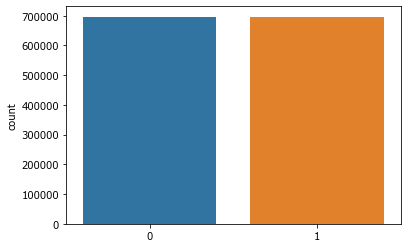

In [29]:
sns.countplot(Y_train_new)

So we shall train various algorithms using the artifically oversampled dataset (X_train_new and Y_train_new) and original training set (X_train and Y_train) and compare the performance of both training procedures on the test set keep the classifier fixed. We shall use precision, recall, f1-score and ROC curve as our metrics

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [31]:
def metrics_report(model, X, Y):
        pred = model.predict(X)
        print("Metrics:\n===========================================")
        print(f"accuracy score: {accuracy_score(Y, pred):.4f}\n")
        print(f"Classification Report: \n \tPrecision: {precision_score(Y, pred)}\n\tRecall Score: {recall_score(Y, pred)}\n\tF1 score: {f1_score(Y, pred)}\n")
        print(f"Confusion Matrix: \n Predicted \n     -       +\n   No       Yes\n {confusion_matrix(Y, pred)}\n")


In [32]:
# Trying a gradient boosting classifier
gradboost = GradientBoostingClassifier(n_estimators = 100, 
                                 max_depth = 6, 
                                 max_features = None)
gradboost.fit(X_train, Y_train)

gradboost_SMOTE = GradientBoostingClassifier(n_estimators = 100, 
                                             max_depth = 6, 
                                             max_features = None)

gradboost_SMOTE.fit(X_train_new, Y_train_new)

GradientBoostingClassifier(max_depth=6)

In [33]:
# Trying a random forest classifier
randfor = RandomForestClassifier(n_jobs = -1, 
                                 n_estimators = 100, 
                                 max_depth = 8, 
                                 class_weight = 'balanced', 
                                 max_features = None)
randfor.fit(X_train, Y_train)

randfor_SMOTE = RandomForestClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       max_depth = 8, 
                                       class_weight = 'balanced', 
                                       max_features = None)

randfor_SMOTE.fit(X_train_new, Y_train_new)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=None,
                       n_jobs=-1)

Precision Definition: Out of all Predictions that were Positive ("Yes"), what percentage were actually positive.

Recall Definition: Out of all records that were actually Positive ("Yes"), what percentage were correctly predicted positive

It makes intuitive sense that as a Supply Chain Manager, we would be more interested in maximizing recall as we want to correctly classify the maximum number of back-order records correctly even if some non-back order records are mistakenly classified as back-order. In other words there is a high cost to misclassifying a back-oder as non back-order but a low cost of missclassifying a non back-order as a back-order.

Since the cost of missclassification isn't symmetric, we have to look into the business needs and figure out which metric should be prioritized. In this case, the recall score is prioritized due to the above mentioned reasons.

In [137]:
# Metrics for original dataset trained Gradient Boosting Classifier
print("----Gradient Boosting Classifier trained on Original Training Dataset---- \n Test Data")
metrics_report(gradboost, X_test, Y_test)
# Metrics for SMOTE dataset trained Gradient Boosting Classifier
print("----Gradient Boosting Classifier trained on SMOTE Dataset---- \n Test Data")
metrics_report(gradboost_SMOTE, X_test, Y_test)

----Gradient Boosting Classifier trained on Original Training Dataset---- 
 Test Data
Metrics:
accuracy score: 0.9924

Classification Report: 
 	Precision: 0.6785714285714286
	Recall Score: 0.14671814671814673
	F1 score: 0.2412698412698413

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[342983    198]
 [  2431    418]]

----Gradient Boosting Classifier trained on SMOTE Dataset---- 
 Test Data
Metrics:
accuracy score: 0.9317

Classification Report: 
 	Precision: 0.0895799581143557
	Recall Score: 0.7957177957177958
	F1 score: 0.1610313965051854

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[320141  23040]
 [   582   2267]]



In [35]:
#visualize recall scores from both SMOTE and non-SMOTE datasets
pd.DataFrame({'Recall Score':pd.Series({'Gradient Boosting Classifier (Original Dataset)':recall_score(Y_test, gradboost.predict(X_test)),
                                        'Gradient Boosting Classifier (SMOTE Dataset)':recall_score(Y_test, gradboost_SMOTE.predict(X_test))})})

,Recall Score
Gradient Boosting Classifier (Original Dataset),0.088265
Gradient Boosting Classifier (SMOTE Dataset),0.771052


We can see that the SMOTE dataset has a higher recall score. The classifier is able to correctly classify 70.6% of backorder records correctly as opposed to 13.49% of the Original dataset. This is because the SMOTE dataset allows the algorithm to 'see' more of the minority class.

Hence we shall use the SMOTE dataset to train all of the other classifiers as well.

In [37]:
# Trying a Gaussian Naive Bayes Classifier
GNB = GaussianNB()
GNB.fit(X_train, Y_train)

GNB_SMOTE = GaussianNB()
GNB_SMOTE.fit(X_train_new, Y_train_new)

GaussianNB()

In [138]:
# Metrics for original dataset trained Naive Bayes Classifier
print("----Guassian Naive Bayes Classifier trained on Original Training Dataset---- \n Test Data")
metrics_report(GNB, X_test, Y_test)
# Metrics for SMOTE dataset trained Naive Bayes Classifier
print("----Guassian Naive Bayes Classifier trained on SMOTE Dataset---- \n Test Data")
metrics_report(GNB_SMOTE, X_test, Y_test)

----Guassian Naive Bayes Classifier trained on Original Training Dataset---- 
 Test Data
Metrics:
accuracy score: 0.0680

Classification Report: 
 	Precision: 0.008578227904145221
	Recall Score: 0.9792909792909793
	F1 score: 0.01700747658424035

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[ 20729 322452]
 [    59   2790]]

----Guassian Naive Bayes Classifier trained on SMOTE Dataset---- 
 Test Data
Metrics:
accuracy score: 0.0741

Classification Report: 
 	Precision: 0.008628934165689155
	Recall Score: 0.9785889785889786
	F1 score: 0.017107023206155585

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[ 22870 320311]
 [    61   2788]]



In [50]:
logreg = make_pipeline(RobustScaler(), LogisticRegression(random_state = 100, class_weight = 'balanced', max_iter = 1000))
logreg.fit(X_train, Y_train)

logreg_SMOTE = make_pipeline(RobustScaler(), LogisticRegression(random_state = 100, class_weight = 'balanced', max_iter = 1000))
logreg_SMOTE.fit(X_train_new, Y_train_new)

C:\Users\chait\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\chait\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=100))])

In [139]:
# Metrics for original dataset trained Naive Bayes Classifier
print("----Logistic Regression Classifier Classifier trained on Original Training Dataset---- \n Test Data")
metrics_report(logreg, X_test, Y_test)
# Metrics for SMOTE dataset trained Naive Bayes Classifier
print("----Logistic Regression Classifier trained on SMOTE Dataset---- \n Test Data")
metrics_report(logreg_SMOTE, X_test, Y_test)

----Logistic Regression Classifier Classifier trained on Original Training Dataset---- 
 Test Data
Metrics:
accuracy score: 0.5893

Classification Report: 
 	Precision: 0.01670009925661653
	Recall Score: 0.8445068445068445
	F1 score: 0.032752518377348216

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[201516 141665]
 [   443   2406]]

----Logistic Regression Classifier trained on SMOTE Dataset---- 
 Test Data
Metrics:
accuracy score: 0.6363

Classification Report: 
 	Precision: 0.016927717468147613
	Recall Score: 0.7564057564057564
	F1 score: 0.03311436364334831

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[218030 125151]
 [   694   2155]]



In [140]:
# Metrics for original dataset trained Random Forest Classifier
print("----Random Forest Classifier trained on Original Training Dataset---- \n Test Data")
metrics_report(randfor, X_test, Y_test)
# Metrics for SMOTE dataset trained Random Forest Classifier
print("----Rnadom Forest Classifier trained on SMOTE Dataset---- \n Test Data")
metrics_report(randfor_SMOTE, X_test, Y_test)

----Random Forest Classifier trained on Original Training Dataset---- 
 Test Data
Metrics:
accuracy score: 0.8925

Classification Report: 
 	Precision: 0.06390433391728235
	Recall Score: 0.8834678834678835
	F1 score: 0.11918742305142534

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[306311  36870]
 [   332   2517]]

----Rnadom Forest Classifier trained on SMOTE Dataset---- 
 Test Data
Metrics:
accuracy score: 0.8798

Classification Report: 
 	Precision: 0.05606105750498499
	Recall Score: 0.8585468585468585
	F1 score: 0.10524956970740103

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[301996  41185]
 [   403   2446]]



In [136]:
def metrics_summary(models_list, model_names, X, Y):
    accuracy = []
    precision = []
    recall = []
    f1_scores = []
    model_name = []
    for model,name in list(zip(models_list, model_names)):
        pred = model.predict(X)
        model_name.append(name)
        accuracy.append(accuracy_score(Y, pred))
        precision.append(precision_score(Y, pred))
        recall.append(recall_score(Y, pred))
        f1_scores.append(f1_score(Y, pred))
    result =  pd.DataFrame({'Model':model_name,
                            'Accuracy':accuracy,
                            'Precision':precision,
                            'Recall':recall,
                            'F1-score':f1_scores})
    result = result.set_index('Model')
    return result

metrics_summary([gradboost_SMOTE, randfor, randfor_SMOTE, GNB_SMOTE, logreg_SMOTE],
                ['Gradient Boosting (SMOTE)', 'Random Forest (Original)', 'Random Forest (SMOTE)', 'Guassian Naive Bayes (SMOTE)', 'Logistic Regression (SMOTE)'],
                X_test, Y_test)
        
            

,Accuracy,Precision,Recall,F1-score
Model,,,,
Gradient Boosting (SMOTE),0.931734,0.089580,0.795718,0.161031
Random Forest (Original),0.892489,0.063904,0.883468,0.119187
Random Forest (SMOTE),0.879814,0.056061,0.858547,0.105250
Guassian Naive Bayes (SMOTE),0.074150,0.008629,0.978589,0.017107
Logistic Regression (SMOTE),0.636318,0.016928,0.756406,0.033114


From the metrics summary, Random Forests (Original) has the best balance between Recall and accuracy. Even though Naive Bayes has the best Recall, its accuracy is very poor to be used for any prediction. Another observation worth pointing out is that the Random Forests Algorithm in sci-kit learn has a 'class-weights' parameter. If we turn this on by giving a value 'balanced', the cost function is weighted inversely to the frequency of classes. This makes the algorithm train in such a way that it prioritizes correctly classifying the minority classes. This negates the neccesity to do SMOTE oversampling on the original dataset. Hence the performances of both SMOTE and Original trained RF classfiers perform similarly on the test data.

Hence from the above summary we shall choose the Original dataset trained Random Forests Classifier as our final model.

Another nice feature about Random Forests is that they are fairly robust to multi-collinearity or predictors with high levels of correlation unlike linear models. On the flip side, multi-collinearity could cause incorrect variable importance plots to be generated hence our interpretations on many of the correlated features might be wrong. Her is an excerpt from Stack-overflow explaining the issue:

"When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.
However once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature.
As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features, But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.
The effect of this phenomenon is somewhat reduced thanks to random selection of features at each node creation, but in general the effect is not removed completely."

Source: https://stats.stackexchange.com/questions/141619/wont-highly-correlated-variables-in-random-forest-distort-accuracy-and-feature

In [161]:
def roc_auc(X, Y, model):
    fpr_, tpr_, thresholds = roc_curve(Y, model.predict_proba(X)[:,0], pos_label = 0)
    auc_model = auc(fpr_, tpr_)
    return fpr_, tpr_, auc_model

def plot_roc_curve(fpr, tpr, auc = None, model_name = None):
    plt.plot(fpr, tpr, linewidth = 2, label = f'AUC ({model_name}) = {round(auc,3)}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right", fontsize=11)
    return

def prec_rec(X, Y, model):
    precision, recall, thresholds = precision_recall_curve(Y, model.predict_proba(X)[:,0], pos_label = 0)
    auc_model = auc(recall, precision)
    return precision, recall, auc_model

def plot_precrec_curve(precision, recall, auc = None, model_name = None):
    plt.plot(recall, precision, label = f'AUC ({model_name}) = {round(auc,5)}')             
    plt.legend(loc= 'lower left')
    plt.xlabel('Recall')
    plt.ylabel ('Precision')
    plt.legend(loc="lower left", fontsize=11)
    return

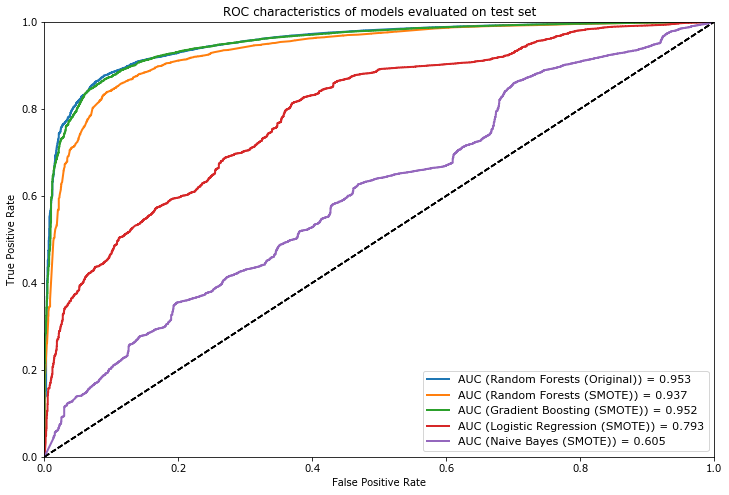

In [165]:
plt.figure(figsize = (12,8))


models = [randfor, randfor_SMOTE, gradboost_SMOTE, logreg_SMOTE, GNB_SMOTE]
model_names = ['Random Forests (Original)', 'Random Forests (SMOTE)',
               'Gradient Boosting (SMOTE)', 'Logistic Regression (SMOTE)', 'Naive Bayes (SMOTE)']
               
for model,name in list(zip(models, model_names)):
    fpr, tpr, auc_model = roc_auc(X_test, Y_test, model)
    plot_roc_curve(fpr, tpr, auc_model, model_name = name)

plt.title('ROC characteristics of models evaluated on test set')
plt.show()


The ROC characteristics also show that the Random Forests model trained on the Original Dataset has the highest Area under the ROC curve(AUC). A good classifier will reach the highest possible TPR (Y-axis) at lower values of FPR (X-axis). Hence the curve of a good classifier will tend to be closer to the top left corner of the plot that other classifiers. This also consequentially increases the Aera under the curve. In other words, we want our classifier to be able to achieve the highest possible True Positive Rate at the lowest possible False Positive Rate. TPR and FPR are both directly proportional to each other.

When we increase our classification threshold probability (most common threshold is 0.5), we will classify more positive values correctly (TPR) but will also classify more neagtive values as positive as a result (FPR).

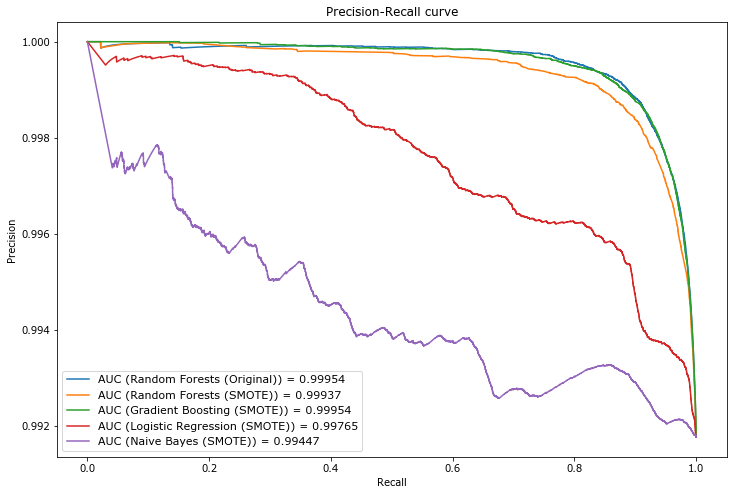

In [185]:
plt.figure(figsize = (12,8))

for model,name in list(zip(models, model_names)):
    precision, recall, auc_model = prec_rec(X_test, Y_test, model)
    plot_precrec_curve(precision, recall, auc_model, model_name = name)

plt.title('Precision-Recall curve')
plt.show()

The precision-recall curves of the models give the same inferences as that from the ROC curves. The random forest model trained on the original dataset is the best model here again due to its highest AUC value. Intuitively, we would like both precision and recall to be as high as possible. Hence the better model should have its curve closer to the top right of the plot (~1.0 recall and ~1.0 precision) than the other curves.

With all the results and plots, we can confidently select the Random Forests Classifier trained on the Original Training set (randfor) as our final prediction model.

Next, we can visualize the variable importance plots for the model below to check which features were more important. Feature importance in random forests is determined by the entropy (impurity) reduction. The feature which consistently gives the best reduction in impurity on splitting gets higher up in the importance list.

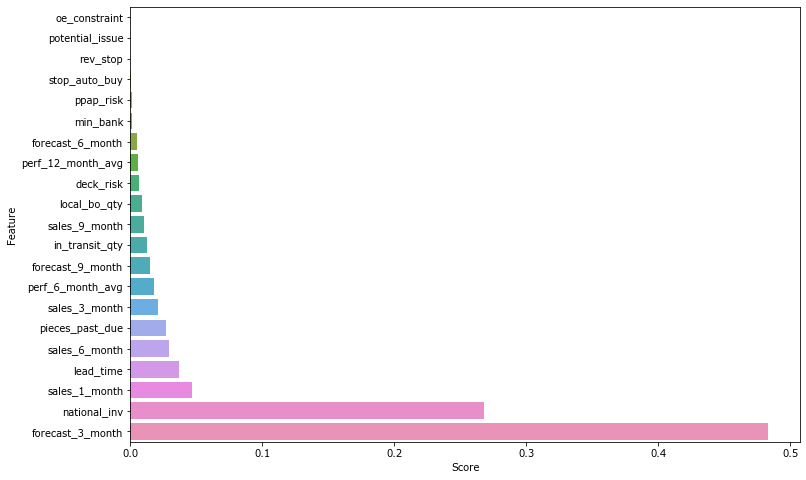

In [179]:
plt.figure(figsize = (12,8))
sns.barplot(x = 'Score',y = 'Feature', 
            data = pd.DataFrame({'Feature':X_train.columns, 'Score':randfor_SMOTE.feature_importances_}).sort_values('Score'))

From the variable importance plot, we can see that forecast_3_month, national_inv, sales_1_month and lead_time are the most important deatures

But variable importance plots in Random Forests are susceptible to multicollinearity (correlation between predictors) as discussed before. This could lead some predictors to have decievingly low variable importance scores due to reasons discussed above.

In [212]:
def scaler_transform(scaler, data):
    cols = data.columns
    return pd.DataFrame(scaler.fit(data).transform(data),columns = cols)

scaled_X = scaler_transform(RobustScaler(), data_presplit)

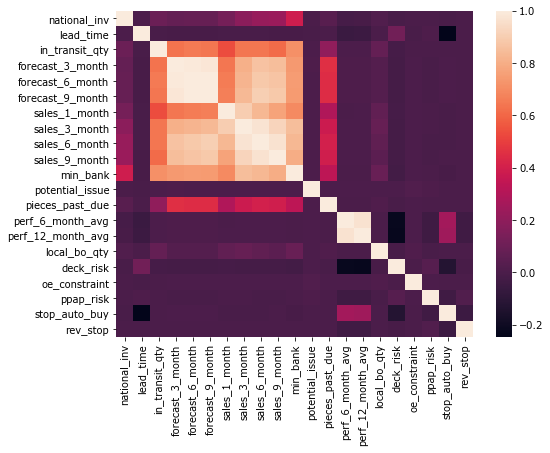

In [204]:
plt.figure(figsize = (8,6))
sns.heatmap(scaled_X.corr())

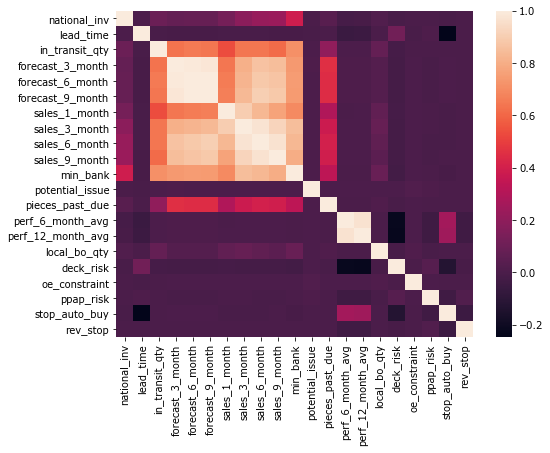

In [205]:
plt.figure(figsize = (8,6))
sns.heatmap(data_presplit.corr())

From the above two plots of the scaled and non-scaled data (data_presplit), we can see that there are a couple of features that are highly correlated. We would like to remove /combine correlated features, retrain the random forest classifier, and re-plot the variable importance plot to see if any previously low importance features become high-importance.

In [213]:
# Feature Engineering
scaled_X['forecast'] = scaled_X['forecast_3_month'] + scaled_X['forecast_6_month'] + scaled_X['forecast_9_month']
scaled_X['sales'] = scaled_X['sales_1_month'] + scaled_X['sales_3_month'] + scaled_X['sales_6_month'] + scaled_X['sales_9_month']
scaled_X['perf'] = scaled_X['perf_6_month_avg'] + scaled_X['perf_12_month_avg']

scaled_X['in_transit_qty + min_bank'] = scaled_X['in_transit_qty'] + scaled_X['min_bank']
#scaled_X['forecast + sales'] = scaled_X['forecast'] + scaled_X['sales']

scaled_X = scaled_X.drop(['forecast_3_month','forecast_6_month','forecast_9_month',
                          'sales_1_month','sales_3_month','sales_6_month','sales_9_month',
                          'perf_6_month_avg','perf_12_month_avg',
                          'in_transit_qty','min_bank','forecast','sales'],axis = 1)

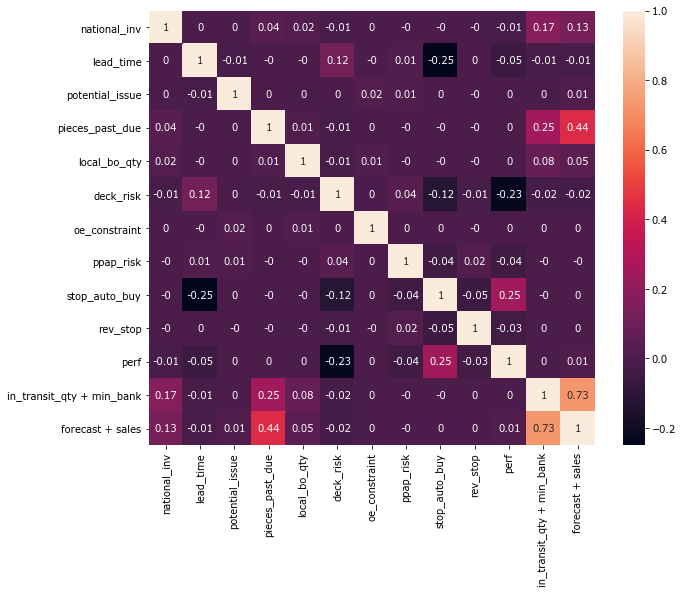

In [214]:
plt.figure(figsize = (10,8))
sns.heatmap(round(scaled_X.corr(),2), annot = True)

In [215]:
Xsc_train, Xsc_test, Ysc_train, Ysc_test = train_test_split(scaled_X, actual_Y, test_size = 0.3)

In [216]:
# Trying a random forest classifier on scaled, feature-engineerd dataset
randfor_scaled = RandomForestClassifier(n_jobs = -1, 
                                 n_estimators = 100, 
                                 max_depth = 8, 
                                 class_weight = 'balanced', 
                                 max_features = None)
randfor_scaled.fit(Xsc_train, Ysc_train)


RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=None,
                       n_jobs=-1)

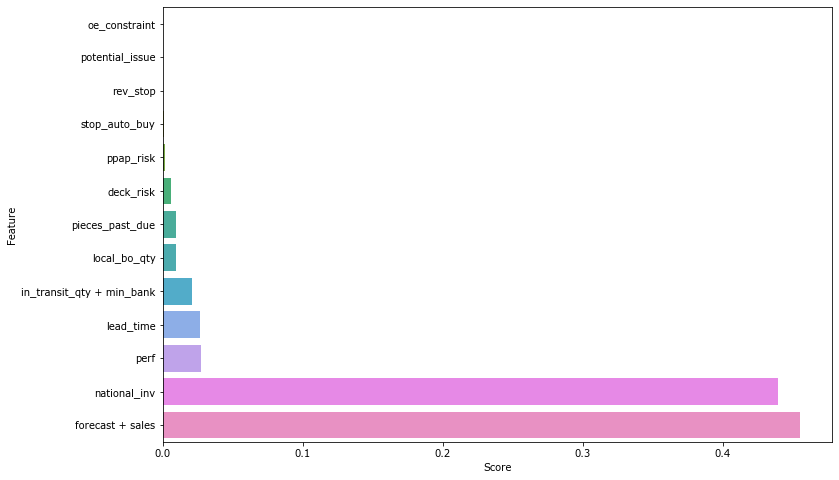

In [217]:
plt.figure(figsize = (12,8))
sns.barplot(x = 'Score',y = 'Feature', 
            data = pd.DataFrame({'Feature':Xsc_train.columns, 'Score':randfor_scaled.feature_importances_}).sort_values('Score'))

In [222]:
# Metrics for original dataset trained Random Forest Classifier
print("----Random Forest Classifier trained on Scaled, Feature Engineered Training Dataset---- \n Test Data")
metrics_report(randfor_scaled, Xsc_test, Ysc_test)

----Random Forest Classifier trained on Scaled, Feature Engineered Training Dataset---- 
 Test Data
Metrics:
accuracy score: 0.8783

Classification Report: 
 	Precision: 0.05616748303040851
	Recall Score: 0.8728748068006182
	F1 score: 0.10554348587847782

Confusion Matrix: 
 Predicted 
     -       +
   No       Yes
 [[274025  37960]
 [   329   2259]]



from the above variable importance plot, we can conclude that the 'perf' feature ('perf_6_month_avg' + 'perf_12_month_avg') has moved into the top 3 whereas previously, the parent features had low scores.

From both importance plots we can conclude that the following original features are important
    + forecast_3_month
    + national_inv
    + sales_1_month
    + lead_time
    + perf_6_month_avg/perf_12_month_avg

The default threshold for the decision-making is 0.5 (probability). This threshold can be tweaked for individual requirements consulting both the ROC curve and Precision - Recall curve of the model. As always, tweaking the threshold involves making a tradeoff between Precision-Recall and TPR-FPR. Based on business requirements/Strategy, a threshold value can be decided. Personally, I would choose a value that maximizes the harmonic mean of accuracy and recall. Recall is important as you wouldn't want to miscclassify backorders as non-backorders at any cost but wouldn't mind if a few non-backorders are mistakenly classified as backorders. In statistical terms, the cost of missclassification of backorders as non-backorders (False Negative) is much higher than the cost of missclassifying non-backorders as backorders (False Positive).